In [1]:
from pycalphad import equilibrium, Database, variables as v
import numpy as np
from time import time
import dask
import os
import pandas as pd
import distributed
import matplotlib.pyplot as plt
%matplotlib inline
client = distributed.Client()


In [2]:
db_files = [ 'Mg-Zn.tdb', 'Cu-Zr_sau.tdb', 'La-Ti.tdb', 'Al-Ni.tdb']


db_path = '/Users/brandon/Box Sync/databases/nims-databases/'
lambda_conditions = lambda s, c: {v.T: 1200, v.P:101325, v.X(c): np.linspace(0, 1, s)}
schedulers = {'muliprocessing': dask.multiprocessing.get, 'sync': dask.async.get_sync, 'client': client.get}

In [3]:
times = []
num_calcs = [10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000]
calc_schedulers = []
calc_dbs = []
calc_num_calcs = []
n_samples = 2

for db_file in db_files:
    dbf = Database(db_path + db_file)
    comps = dbf.elements - {'/-'}
    comp = list(comps - {'VA'})[0]
    for sched_name, scheduler in schedulers.items():
        for calc_size in num_calcs:
            for _ in range(n_samples):
                conds = lambda_conditions(calc_size, comp)
                start_time = time()
                equilibrium(dbf, comps, list(dbf.phases.keys()), conds, scheduler=scheduler)
                times.append(time() - start_time)
                calc_schedulers.append(sched_name)
                calc_dbs.append(db_file)
                calc_num_calcs.append(calc_size)


/Users/brandon/.virtualenvs/pycalphad/lib/python3.5/site-packages/dask/async.py:13: UserWarning: `dask.async.get_sync` has been moved to `dask.local.get_sync`, please update your imports
  warnings.warn(_msg.format('get_sync'))


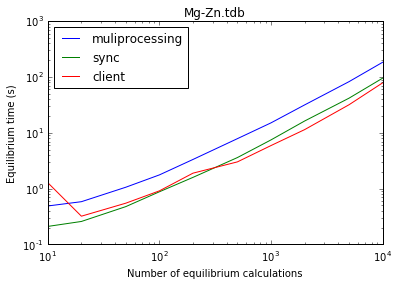

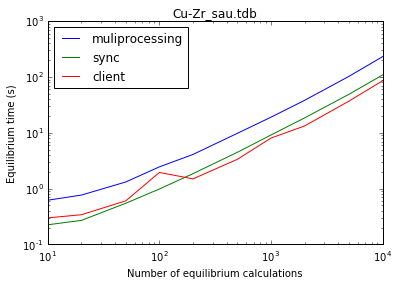

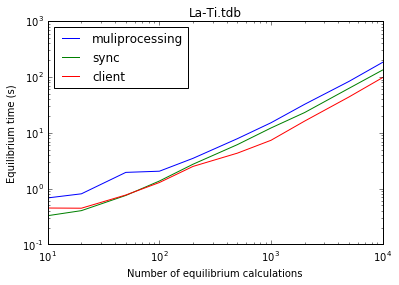

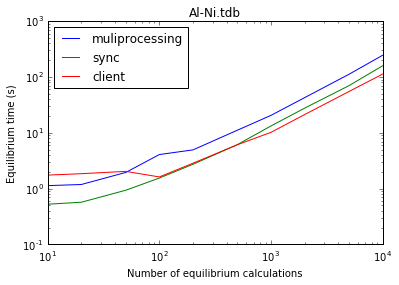

In [8]:
if not os.path.exists('pycalphad-timings-results'):
    os.mkdir('pycalphad-timings-results')

raw_df = pd.DataFrame({'Time': times,
                    'N': calc_num_calcs,
                    'db': calc_dbs,
                    'scheduler': calc_schedulers})
df = pd.DataFrame({'mean_time': raw_df.groupby(['N', 'db', 'scheduler'])['Time'].mean()}).reset_index()

labels=[]
for db in db_files:
    f = plt.figure()
    ax = f.gca()
    for scheduler in schedulers.keys():
        ax = df.select((lambda x: (df.iloc[x]['db'] == db) and (df.iloc[x]['scheduler'] == scheduler))).plot(ax=ax, x='N', y='mean_time', loglog=True)
        labels.append(scheduler)
    ax.legend(labels, loc=0)
    ax.set_title(db)
    ax.set_ylabel('Equilibrium time (s)')
    ax.set_xlabel('Number of equilibrium calculations')
    f.savefig(os.path.join('pycalphad-timings-results', os.path.splitext(db)[0]+'-log.png'))
        

In [5]:
print(raw_df)
raw_df.to_csv('pycalphad-timings-results/timings-dataframe.csv')

         N        Time         db       scheduler
0       10    0.525180  Mg-Zn.tdb  muliprocessing
1       10    0.454135  Mg-Zn.tdb  muliprocessing
2       20    0.589075  Mg-Zn.tdb  muliprocessing
3       20    0.579956  Mg-Zn.tdb  muliprocessing
4       50    1.034464  Mg-Zn.tdb  muliprocessing
5       50    1.088633  Mg-Zn.tdb  muliprocessing
6      100    1.754083  Mg-Zn.tdb  muliprocessing
7      100    1.777006  Mg-Zn.tdb  muliprocessing
8      200    3.429311  Mg-Zn.tdb  muliprocessing
9      200    3.250291  Mg-Zn.tdb  muliprocessing
10     500    7.824561  Mg-Zn.tdb  muliprocessing
11     500    7.931144  Mg-Zn.tdb  muliprocessing
12    1000   15.328778  Mg-Zn.tdb  muliprocessing
13    1000   14.909599  Mg-Zn.tdb  muliprocessing
14    2000   31.174523  Mg-Zn.tdb  muliprocessing
15    2000   32.192319  Mg-Zn.tdb  muliprocessing
16    5000   82.991130  Mg-Zn.tdb  muliprocessing
17    5000   82.515737  Mg-Zn.tdb  muliprocessing
18   10000  183.639904  Mg-Zn.tdb  muliprocessing
